In [1]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection

In [2]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:03<00:00, 6123.17it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [3]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [4]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'fruity', 'cherry', 'banana', 'tropical', 'sweet', 'pineapple'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [140]:
class SOM(object):
    def __init__(self,width,height,lr=1e-1,gauss=10,decay=.99):
        self.vectors = torch.rand((width,height,len(all_notes)))
        
        map_x_idx, map_y_idx = torch.meshgrid(torch.arange(start=0,end=width), torch.arange(start=0,end=height), indexing='ij')
        self.map_idx = torch.stack([map_x_idx,map_y_idx],dim=-1)

        self.lr = lr
        self.gauss = gauss
        self.decay = decay

    def do_decay(self):
        self.lr *= self.decay
        self.gauss *= self.decay

    def get_activations(self,encoding):
        # Activation is 1 / Euclidian(vectors, encoding).
        # The closer a vector is to the encoding, the higher the activation.
        return 1/(self.vectors-encoding).square().sum(dim=-1).sqrt()

    def get_bmu(self,encoding):
        actvtn = self.get_activations(encoding)
        bmu_idx = (actvtn==torch.max(actvtn)).nonzero()
        return bmu_idx[0]

    def get_loss(self,encoding):
        actvtn = self.get_activations(encoding)
        # Convert back to distances to calculate loss
        # The loss is the lowest distance, so minimizing loss
        # means a better match.
        return torch.min(1/actvtn)

    def get_distances(self,bmu):
        xy_dist = self.map_idx - bmu
        return torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))

    def update_factor(self,bmu):
        dists = self.get_distances(bmu)
        # Gaussian distribution centered on BMU of width 2^gauss.
        return torch.exp(torch.neg(torch.div(dists.square(), 2**self.gauss)))

    def get_deltas(self,encoding):
        return encoding-self.vectors

    def update_step(self,encoding):
        bmu = self.get_bmu(encoding)
        uf = self.update_factor(bmu)
        deltas = self.get_deltas(encoding)
        self.vectors += self.lr*uf.unsqueeze(-1)*deltas

mm = SOM(3,2,lr=1)
e0 = molecules[0]["encoding"]
bmu0 = mm.get_bmu(e0)
# When we call update with lr=1, we expect the update vector of the bmu to match the encoding
mm.update_step(e0)
mm.vectors.shape
assert torch.all(mm.vectors[bmu0[0],bmu0[1]] == e0)
print(bmu0)

tensor([2, 1])


In [141]:
train_mols, test_mols = sklearn.model_selection.train_test_split(molecules)

def do_train(config,verbose=False):
    total_steps = config["epochs"]*len(train_mols)
    lrs = []
    losses = []

    som = SOM(width=config["width"],
              height=config["height"],
              lr=config["lr"],
              gauss=config["gauss"],
              decay=config["decay"])
    
    def do_train_step(s):
        slr = config["lr"]*(1 - (s/total_steps))
        mol = random.choice(train_mols)
        return som.update_step(mol["encoding"])
    
    def get_test_loss():
        es = []
        for mol in test_mols:
            es.append(som.get_loss(mol["encoding"]))
        return np.mean(es)

    for s in tqdm.tqdm(range(total_steps),smoothing=0, disable=not verbose):
        do_train_step(s)
        if s % 100 == 0:
            losses.append(get_test_loss())
            som.do_decay()

    return som, losses

100%|████████████████████████████████████| 25800/25800 [00:39<00:00, 649.42it/s]


1.8646358


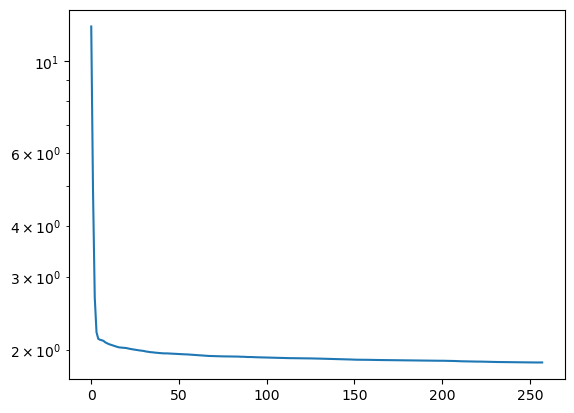

In [142]:
som, loss = do_train({'width': 25, 'height': 20, 'epochs': 10, 'lr': 1e-2, "gauss":1, "decay": 1},verbose=True)
# plt.set_ylim(0, 1)
plt.yscale('log')
plt.plot(loss)
print(loss[-1])

In [148]:
def flatten(mtrx):
    return mtrx.reshape((mtrx.shape[0]*mtrx.shape[1],-1)).squeeze()

def plot(title,encoding,as_size,factor=80,thresh=1e-5):
    bmu = som.get_bmu(encoding)
    activations = som.get_activations(encoding)
    
    act = flatten(activations)
    minv, maxv = act.min().numpy(), act.max().numpy()
    
    pos = flatten(som.map_idx).numpy()
    
    if as_size:
        # For very very small values, matplotlib will underflow and draw circles where it should draw tiny circles.
        act = torch.nn.functional.threshold(act,thresh,0)
        plt.scatter(pos[:,0],pos[:,1],s=factor*act.numpy())
    else:
        plt.scatter(pos[:,0],pos[:,1],c=factor*act.numpy())
        plt.set_cmap('PiYG_r')
        plt.colorbar()
        # cbar.lim(minv,maxv)

    plt.title(f"{title}\nBMU of {bmu.numpy()} w/ value = {activations[bmu[0],bmu[1]]}. Range = ({minv:.2f}, {maxv:.2f})")


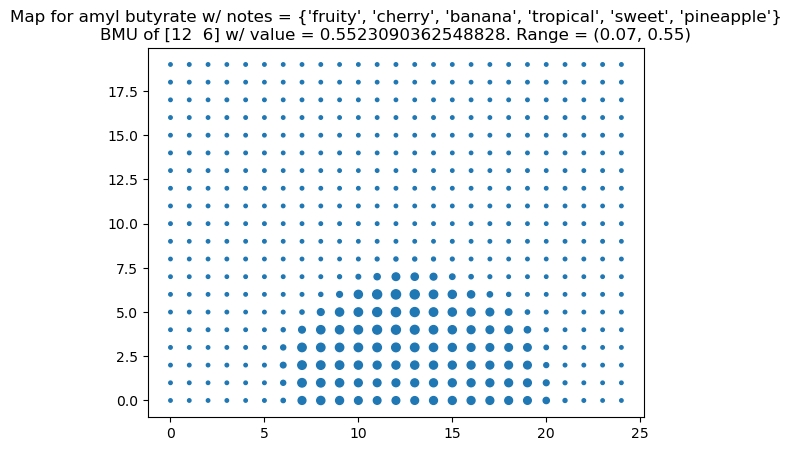

In [149]:
plot(f"Map for {molecules[0]['name']} w/ notes = {molecules[0]['notes']}",
     molecules[0]["encoding"],
     as_size=True)

plt.show()

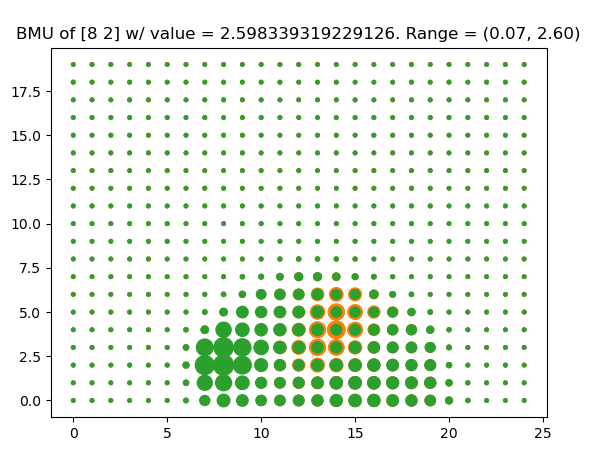

In [158]:
plot("",multi_hot(["musk"]),as_size=True,thresh=1e-5)
plot("",multi_hot(["sweet"]),as_size=True,thresh=1e-5)
plot("",multi_hot(["fruity"]),as_size=True,thresh=1e-5)
plt.show()
